In [ ]:
from math import log10,sqrt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from tensorflow.keras import backend as K


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install matplotlib==3.1.3

In [ ]:
!pip install wfdb

     |████████████████████████████████| 137 kB 5.3 MB/s 
     |████████████████████████████████| 11.2 MB 43.8 MB/s 
     |████████████████████████████████| 895 kB 44.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install padasip

     |████████████████████████████████| 47 kB 2.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir
import wfdb
import os
from skimage.restoration import denoise_wavelet
import padasip as pa
from scipy.ndimage import gaussian_filter1d
from scipy import signal,stats
import cv2
import scipy
from sklearn.metrics import mean_squared_error 

In [ ]:
!unzip /content/drive/MyDrive/research1/mit-bih-arrhythmia-database-1.0.0.zip -d /content/drive/MyDrive/research1

Archive:  /content/drive/MyDrive/research1/mit-bih-arrhythmia-database-1.0.0.zip
replace /content/drive/MyDrive/research1/mit-bih-arrhythmia-database-1.0.0/100.atr? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_path='/content/drive/MyDrive/research1/mit-bih-arrhythmia-database-1.0.0/'


In [ ]:
#list of patients
pts=['100','101','102','103','104','105','106','107',
     '108','109','111','112','113','114','115','116',
     '117','118','119','121','122','123','124','200',
     '201','202','203','205','207','208','209','210',
     '212','213','214','215','217','219','220','221',
     '222','223','228','230','231','232','233','234']

In [ ]:
df=pd.DataFrame()

for pt in pts:
    file = data_path+pt
    annotation = wfdb.rdann(file,'atr')
    sym=annotation.symbol
    
    values,counts = np.unique(sym,return_counts=True)
    df_sub=pd.DataFrame({'sym':values,'val':counts,'pt':[pt]*len(counts)})
    df = pd.concat([df,df_sub],axis=0)
print(df)

    

   sym   val   pt
0    +     1  100
1    A    33  100
2    N  2239  100
3    V     1  100
0    +     1  101
..  ..   ...  ...
0    +     3  234
1    J    50  234
2    N  2700  234
3    V     3  234
4    ~     8  234

[283 rows x 3 columns]


In [ ]:
df.groupby('sym').val.sum().sort_values(ascending=False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [ ]:
#list of nonbeat and abnormal
nonbeat=['[','!',']','x','(',')','p','t','u','`','\'','^','|','~','+','s','T','D',
        '=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

normal=['N']

In [ ]:
df['cat']=-1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal),'cat'] = 1
df

,sym,val,pt,cat
0,+,1,100,-1
1,A,33,100,1
2,N,2239,100,0
3,V,1,100,1
0,+,1,101,-1
...,...,...,...,...
0,+,3,234,-1
1,J,50,234,1
2,N,2700,234,0
3,V,3,234,1


In [ ]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [ ]:
def load_ecg(file):
    record=wfdb.rdrecord(file)
    annotation=wfdb.rdann(file,'atr')
    p_signal = record.p_signal
    assert record.fs == 360,'sample freq is not 360'
    
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    return p_signal,atr_sym,atr_sample
   

In [ ]:
file = data_path + pts[0]

In [ ]:
p_signal,atr_sym,atr_sample = load_ecg(file)



In [ ]:
values,counts = np.unique(sym,return_counts=True)
for v,c in zip(values,counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [ ]:
#get normal beat index 
n_index = [l for m,l in zip(atr_sym,atr_sample) if m in normal][:10]
n_index


[77, 370, 662, 946, 1231, 1515, 1809, 2402, 2706, 2998]

In [ ]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [ ]:
x=np.arange(len(p_signal))


In [ ]:
left = ab_index[1]-1080
right = ab_index[1]+1080

print(left)
print(right)

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg')
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label='normal')
plt.plot(x[ab_index],p_signal[ab_index:,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1),loc='upper left')
plt.show()

65712
67872


TypeError: ignored

ImportError: ignored

<Figure size 432x288 with 1 Axes>

1918
4078


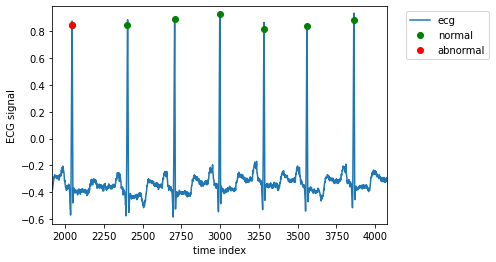

In [ ]:
left = n_index[9]-1080
right =n_index[9]+1080

print(left)
print(right)

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg')
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1),loc='upper left')
plt.show()

In [ ]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'
    return X_all, Y_all, sym_all
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0
    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):
        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [ ]:
num_sec = 3
fs = 360
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs,abnormal)
X_all
p=X_all[2,:]







/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: As of scikit-image 0.16, automated rescaling of sigma to match any internal rescaling of the image is performed. Setting rescale_sigma to False, will disable this new behaviour. To avoid this warning the user should explicitly set rescale_sigma to True or False.
  


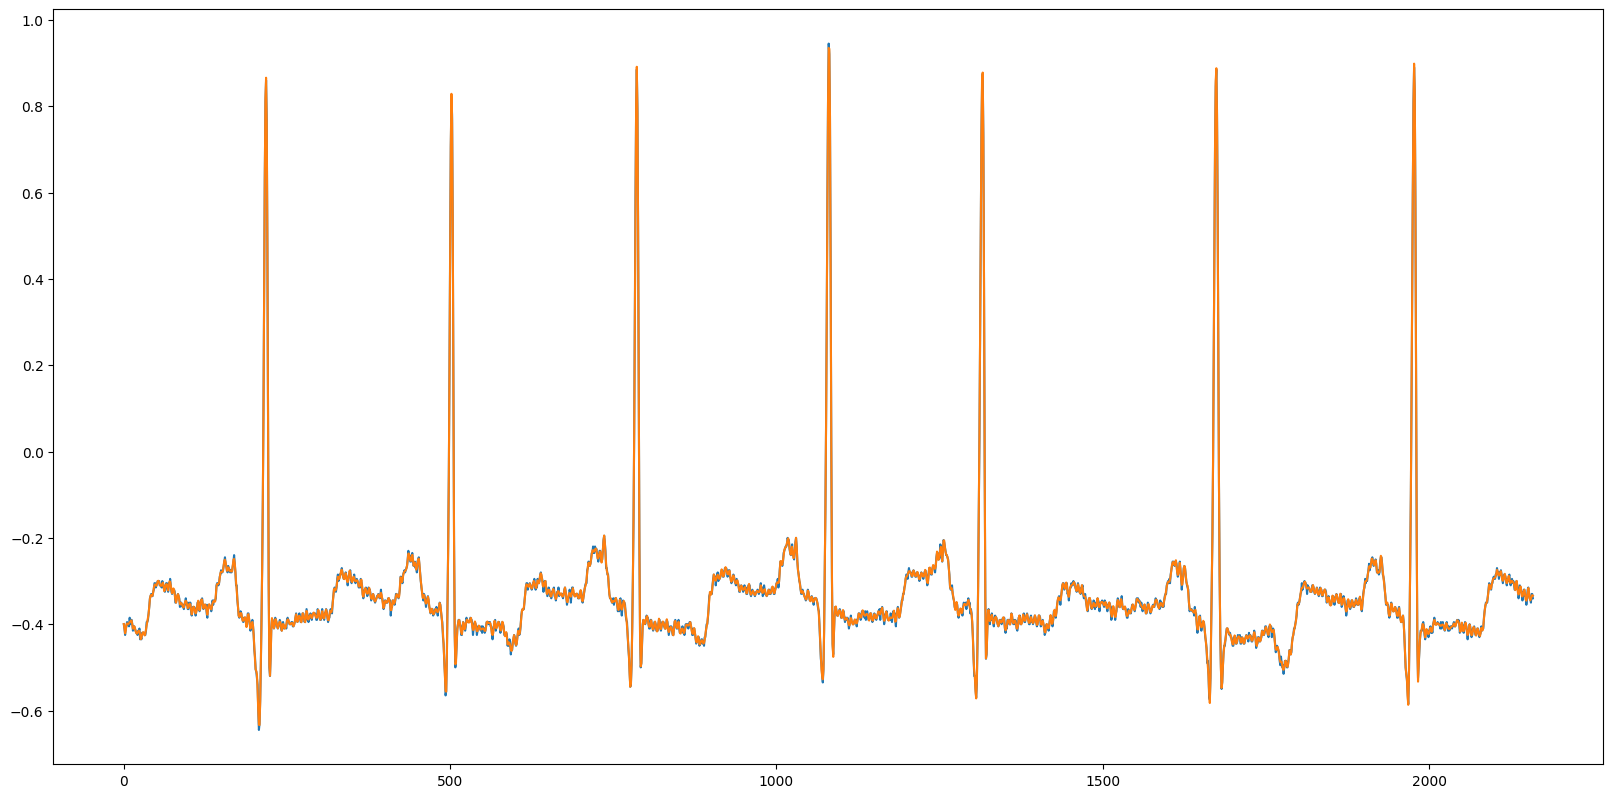

In [ ]:
#wavelet Denoising 
x_denoise = denoise_wavelet(p,method='BayesShrink',mode='soft',wavelet_levels=3,wavelet='sym8')
plt.figure(figsize=(20,10),dpi=100)
plt.plot(p)
plt.plot(x_denoise)

2160

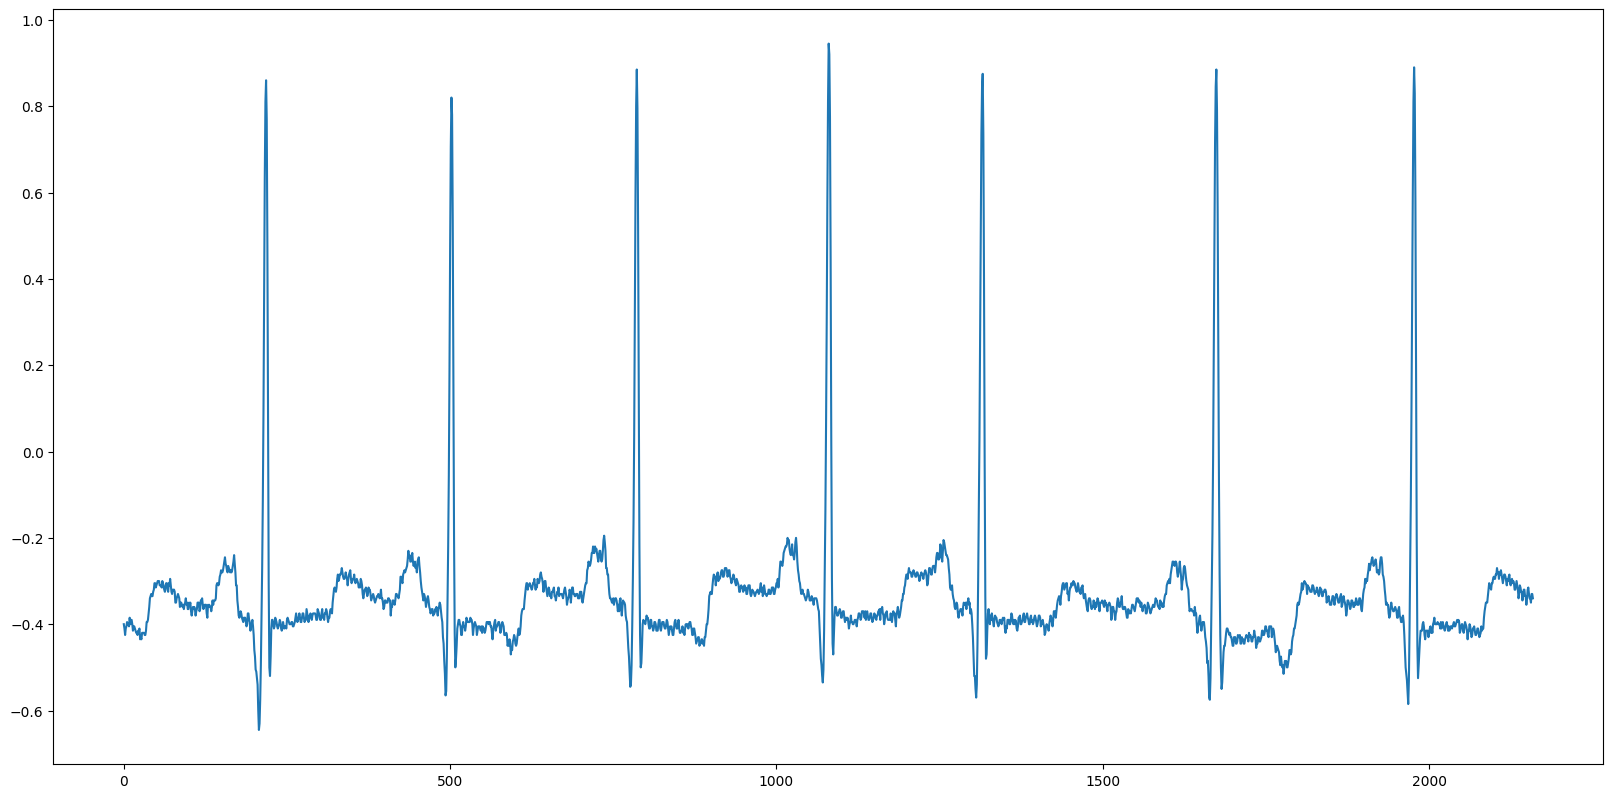

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(p)
len(p)

array([-0.39955742, -0.40936844, -0.42113852, ..., -0.33656309,
       -0.33264164, -0.33389939])

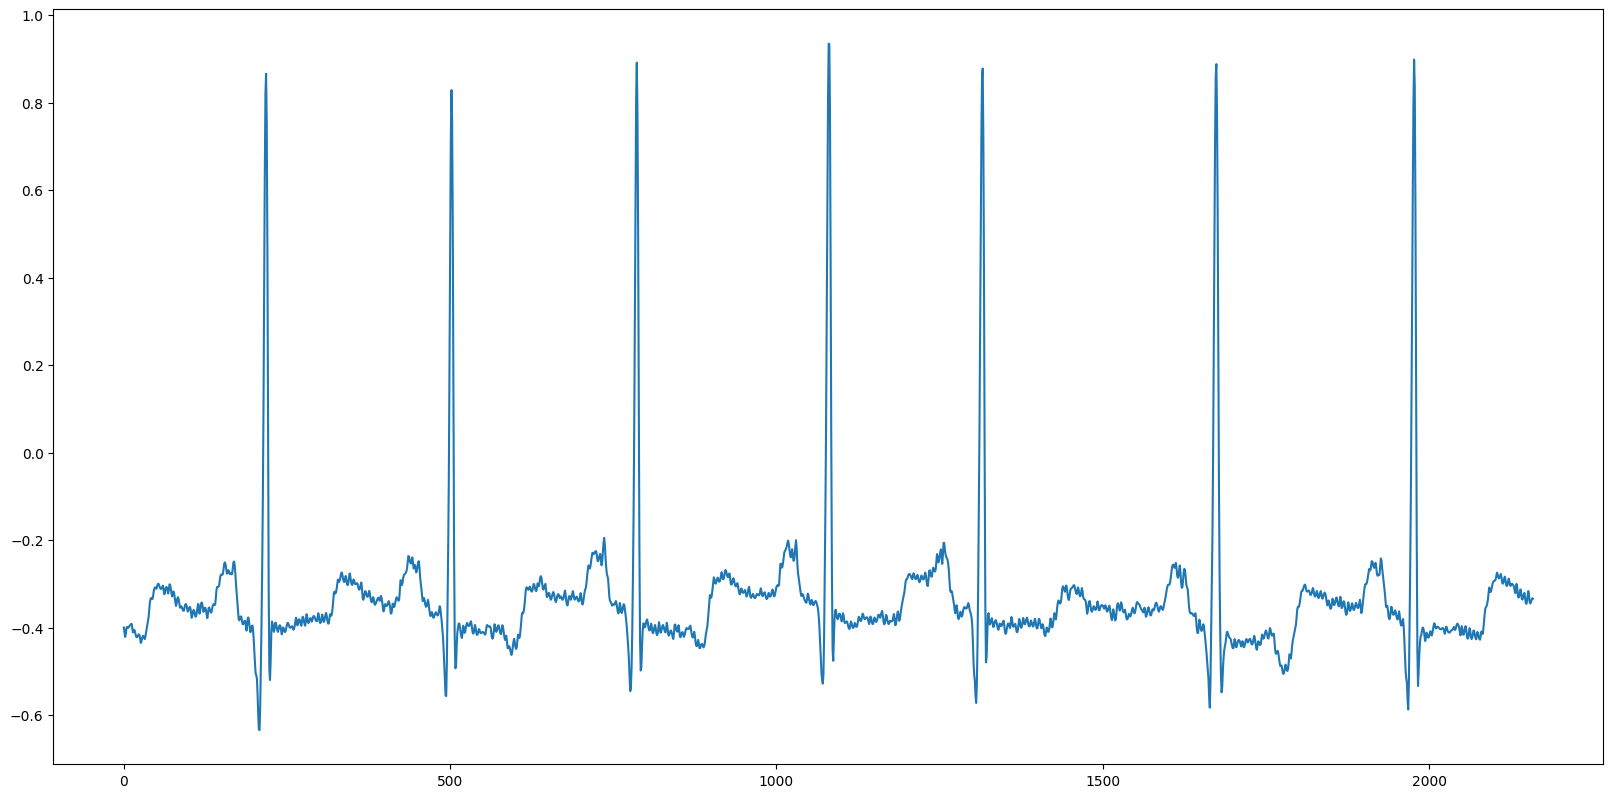

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(x_denoise)
x_denoise 

In [ ]:
p_all=[]
for i in X_all:
    x_denoise = denoise_wavelet(i,method='BayesShrink',mode='soft',wavelet_levels=3,wavelet='sym8')
    p_all.append(x_denoise)
p_all

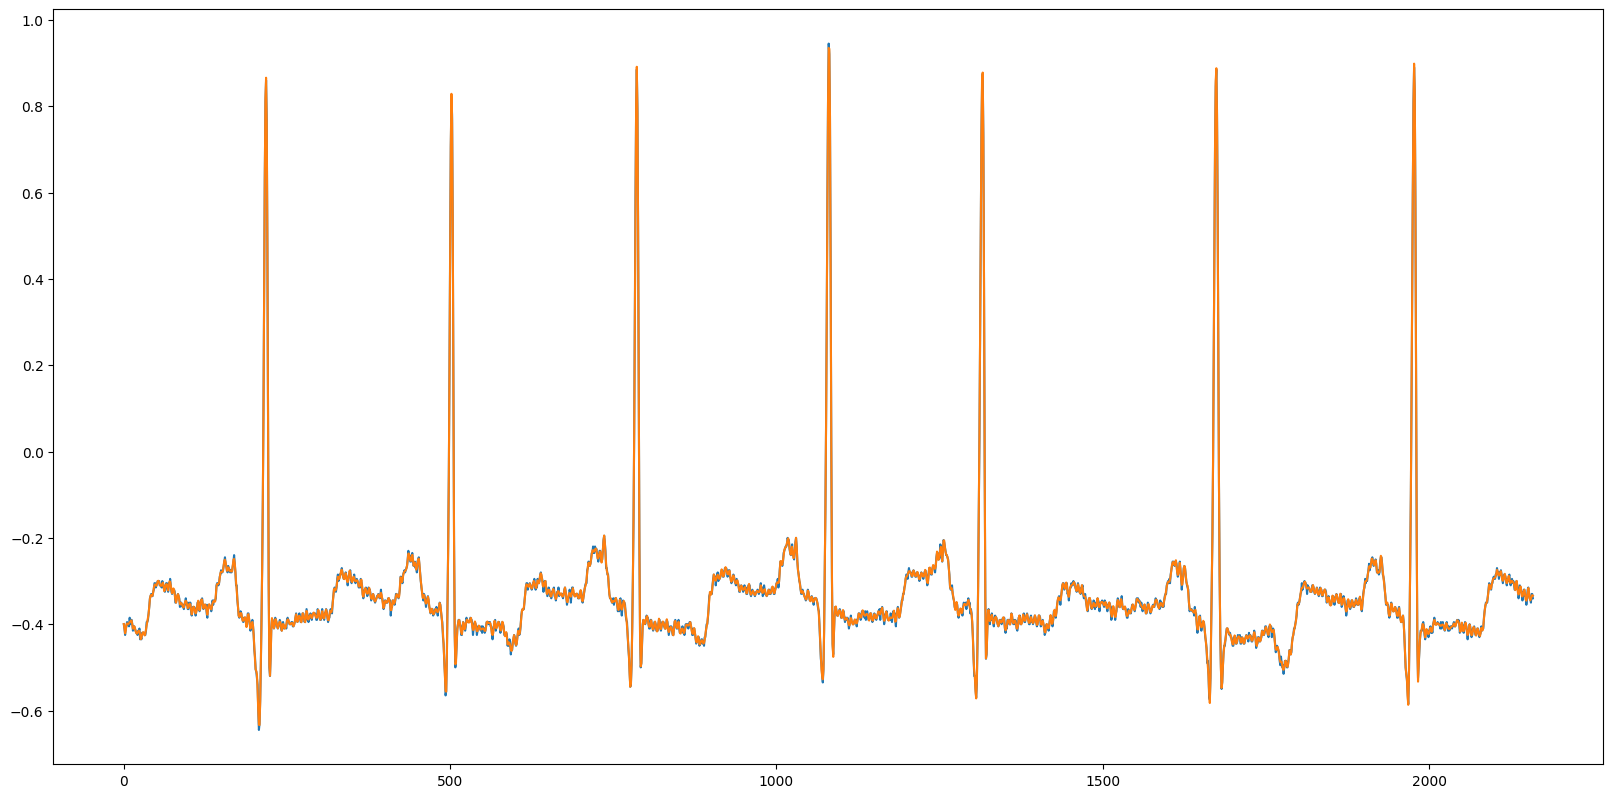

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(p)
plt.plot(p_all[2])


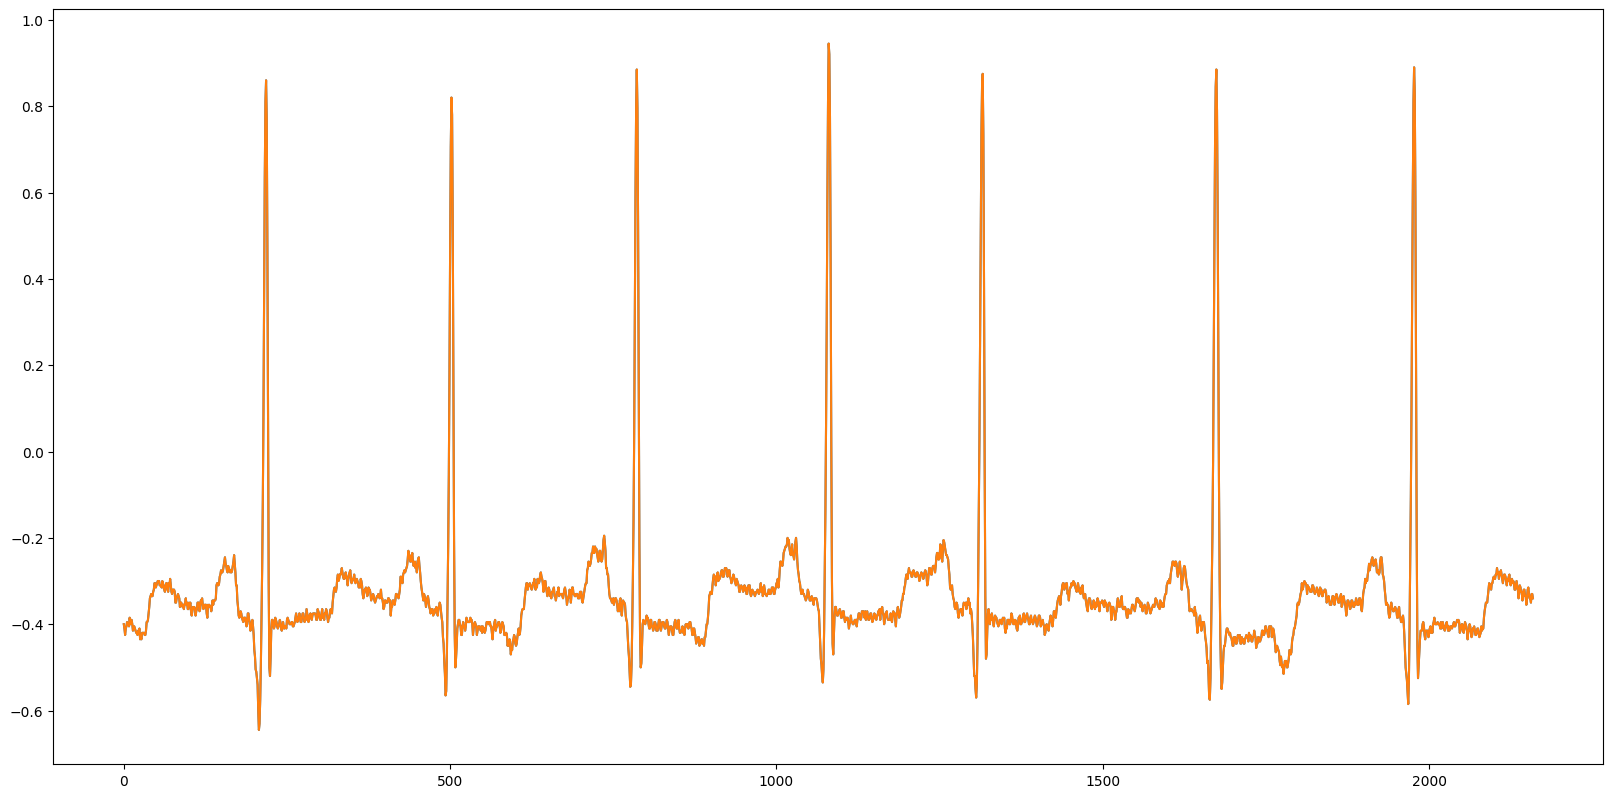

In [ ]:
median = cv2.medianBlur(p,1)
plt.figure(figsize=(20,10),dpi=100)
plt.plot(p)
plt.plot(median)


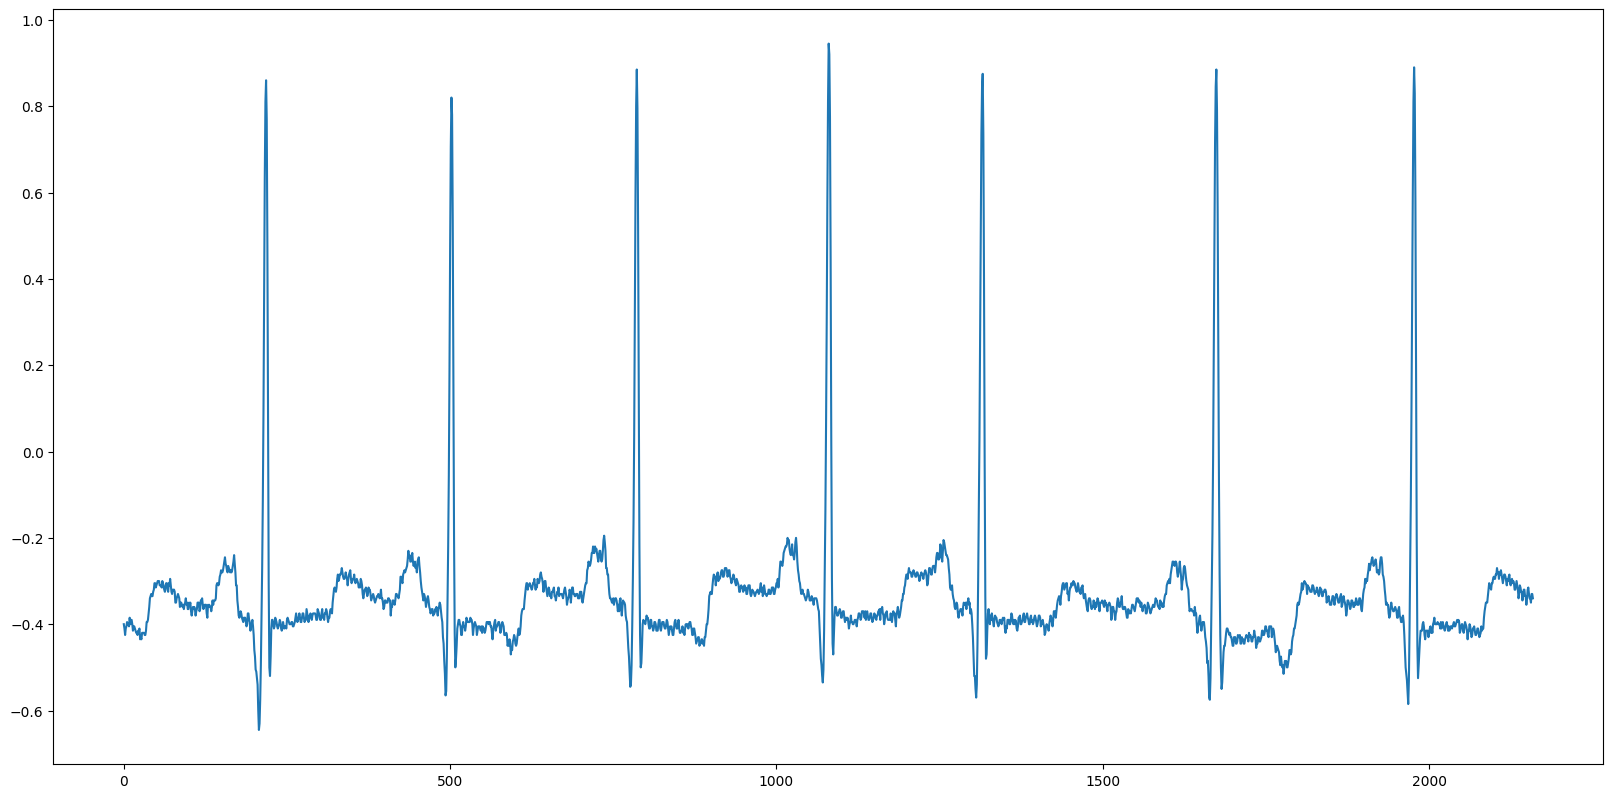

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(p)

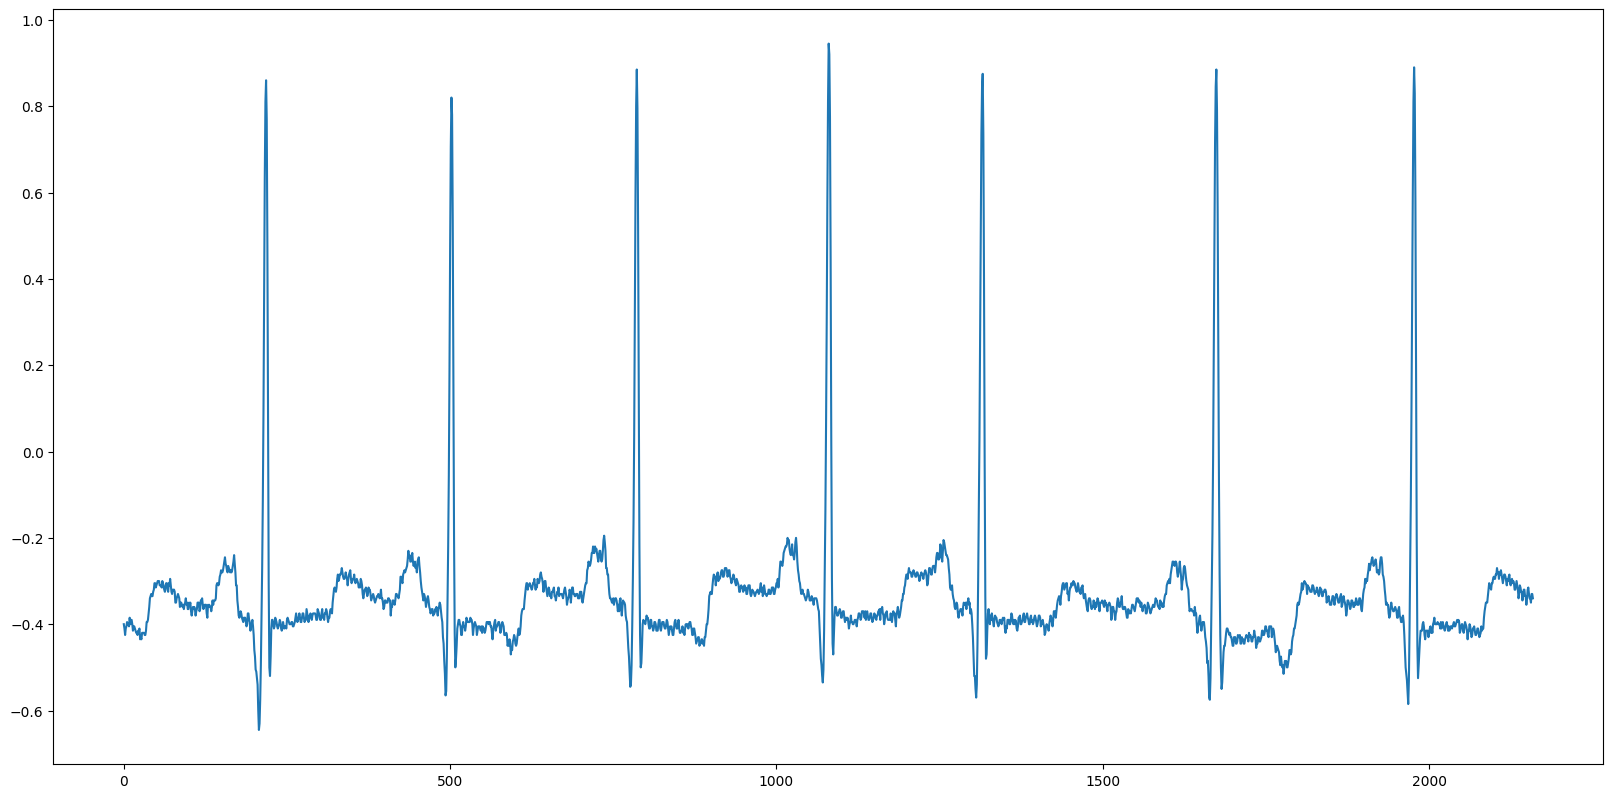

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(median)

In [ ]:
median_all=[]
for i in X_all:
    median = cv2.medianBlur(i,1)
    median_all.append(median)
 

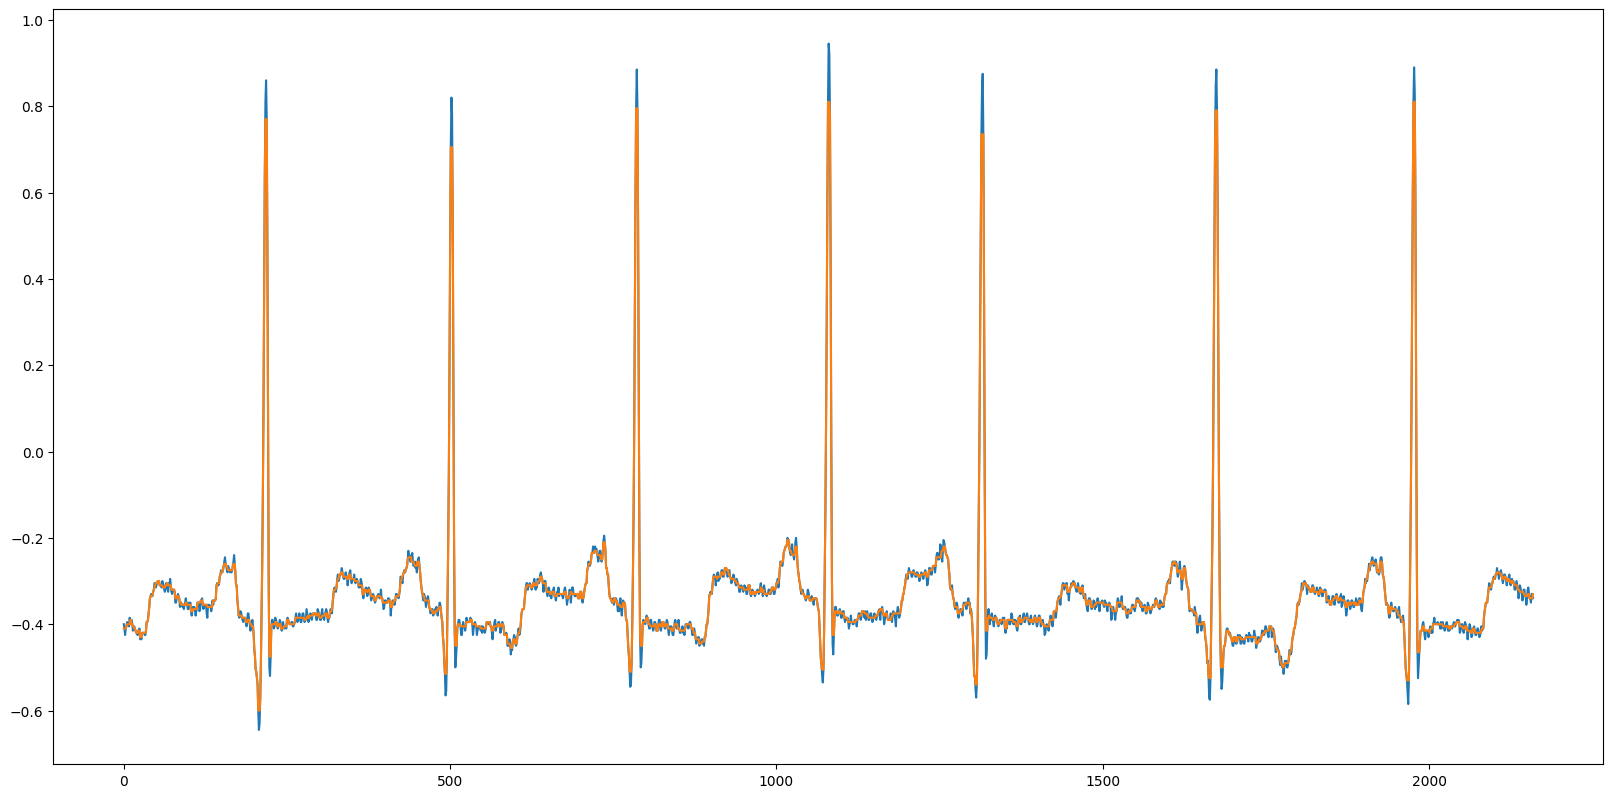

In [ ]:
#implementing median filter using scipy
plt.figure(figsize=(20,10),dpi=100)
med=scipy.ndimage.median_filter(p,size=5)
plt.plot(p)
plt.plot(med)

In [ ]:
#implementation of gussian filter 1d
gua=gaussian_filter1d(p,1)
gua

array([-0.40446653, -0.41064779, -0.41506215, ..., -0.33600789,
       -0.33408511, -0.3365018 ])

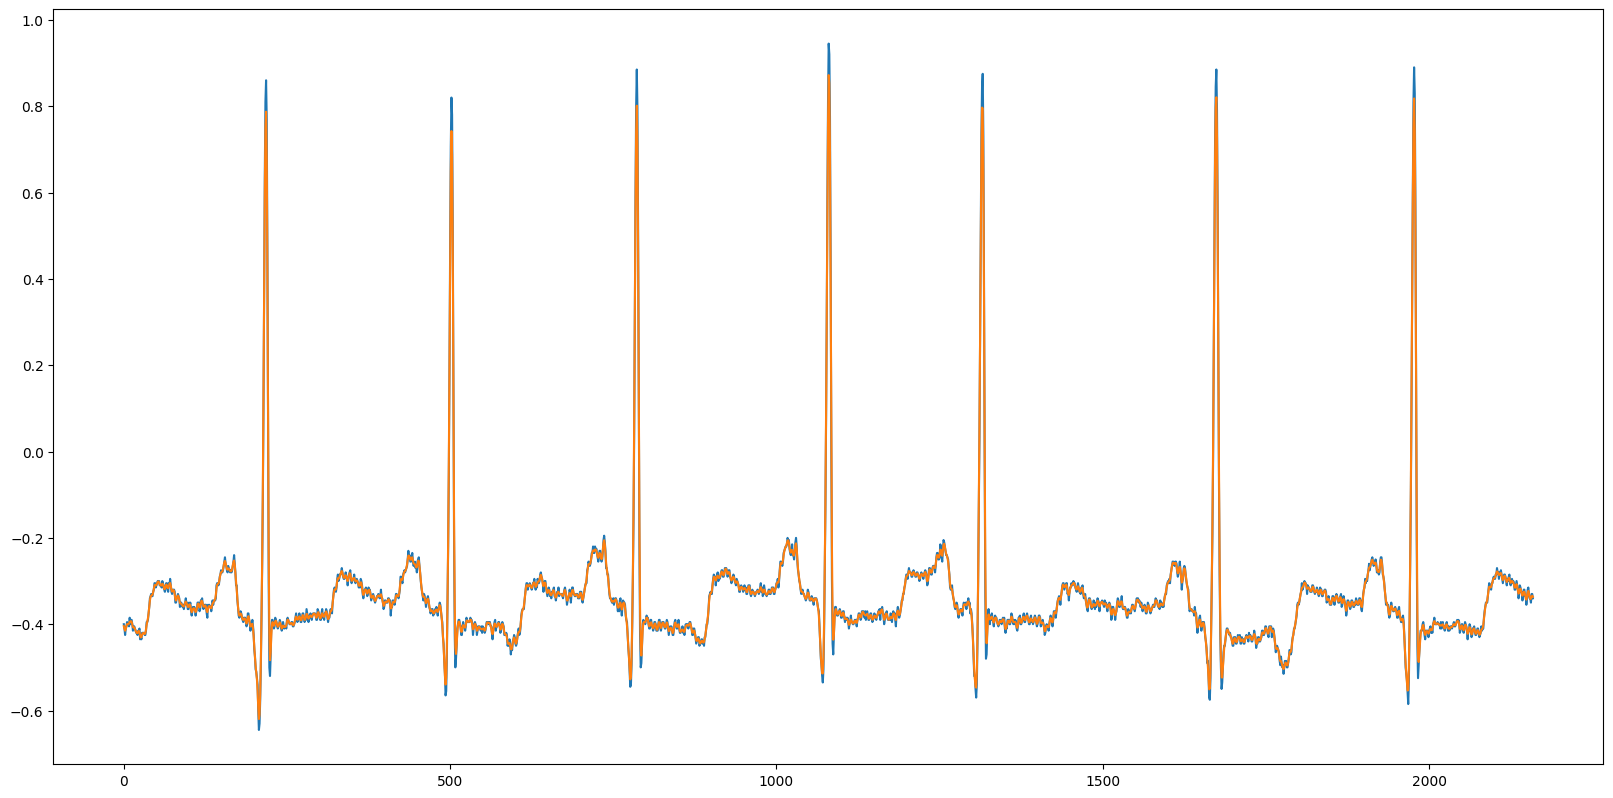

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(p)
plt.plot(gua)

In [ ]:
#moving average 
filter_length = 5
tair_moving_average = np.convolve(p,np.ones((filter_length)),mode='same')
tair_moving_average/=filter_length

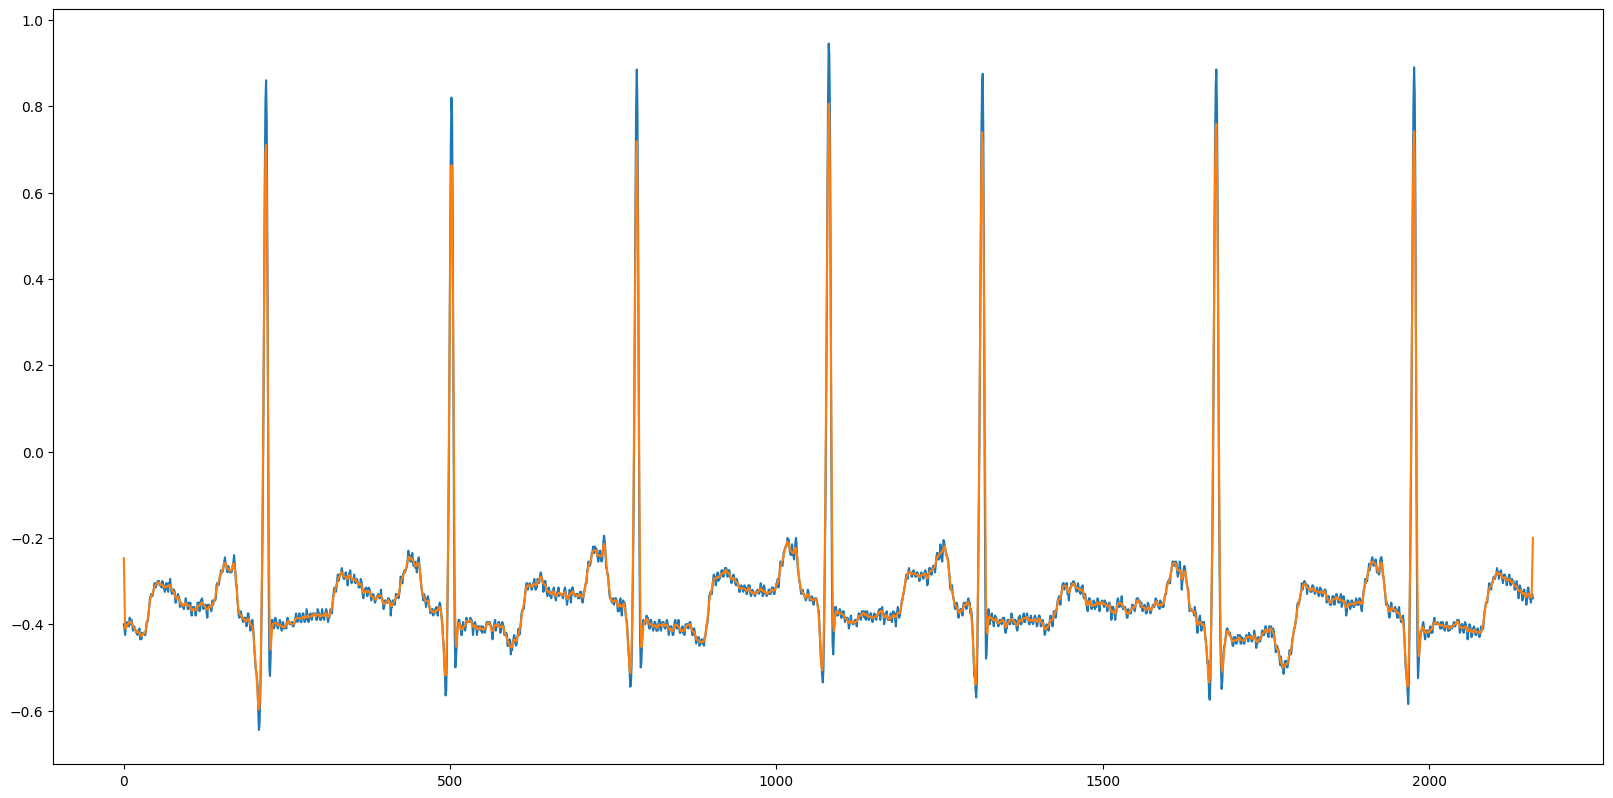

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(p)
plt.plot(tair_moving_average)

In [ ]:
#savitzky-golay filter 
sg_filtered = signal.savgol_filter(p,25,7)


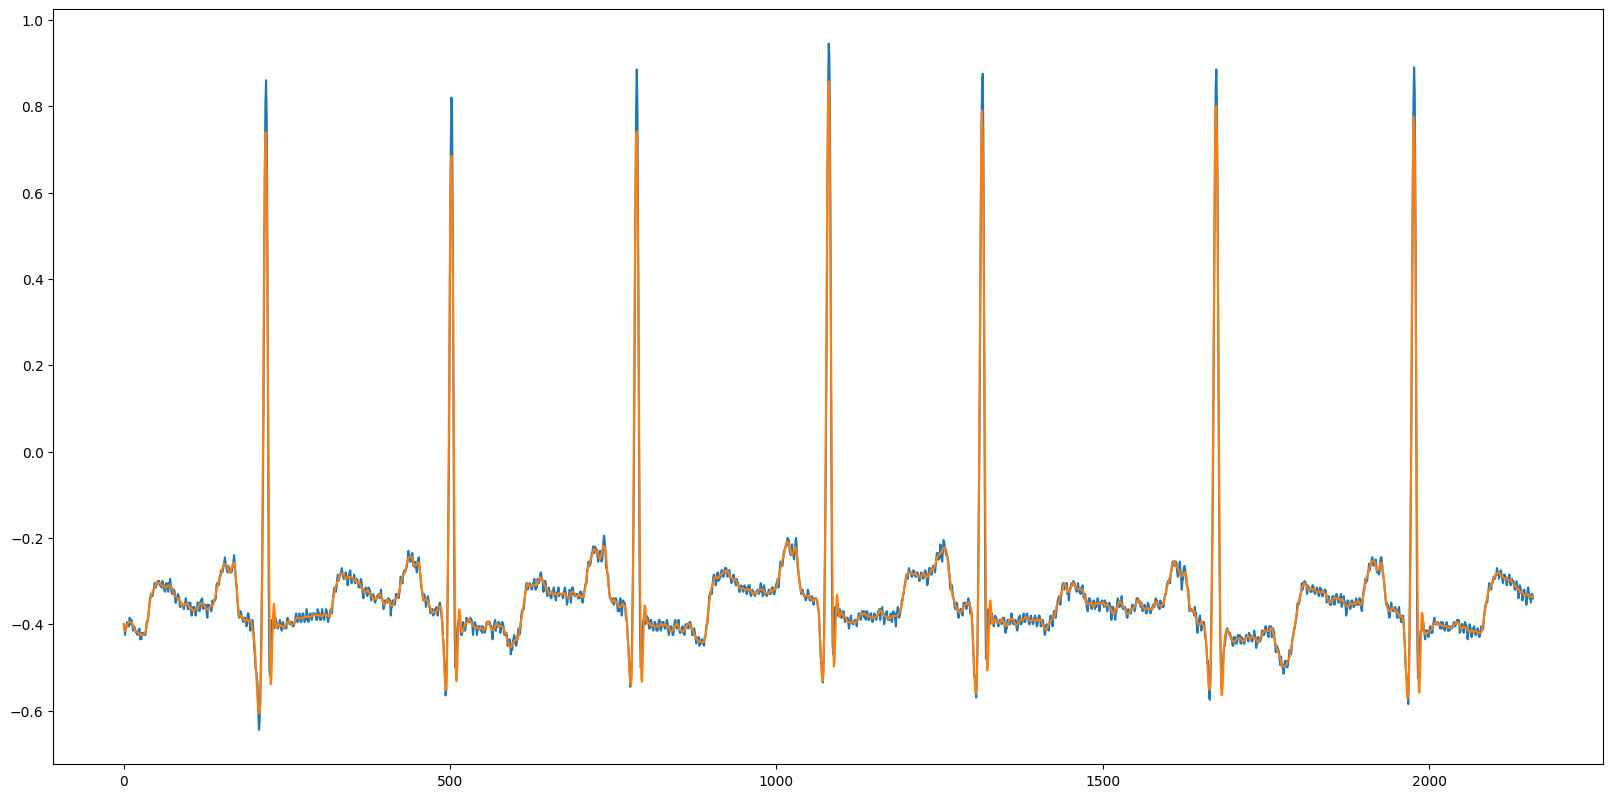

In [ ]:
plt.figure(figsize=(20,10),dpi=100)

plt.plot(p)
plt.plot(sg_filtered)

In [ ]:
#low pass butterworth filter 
bwf=signal.butter(3,120,'low',fs=360,output='sos')
filt=signal.sosfilt(bwf,p)
filt

array([-0.13272205, -0.40602598, -0.47784223, ..., -0.34294268,
       -0.33179913, -0.3292816 ])

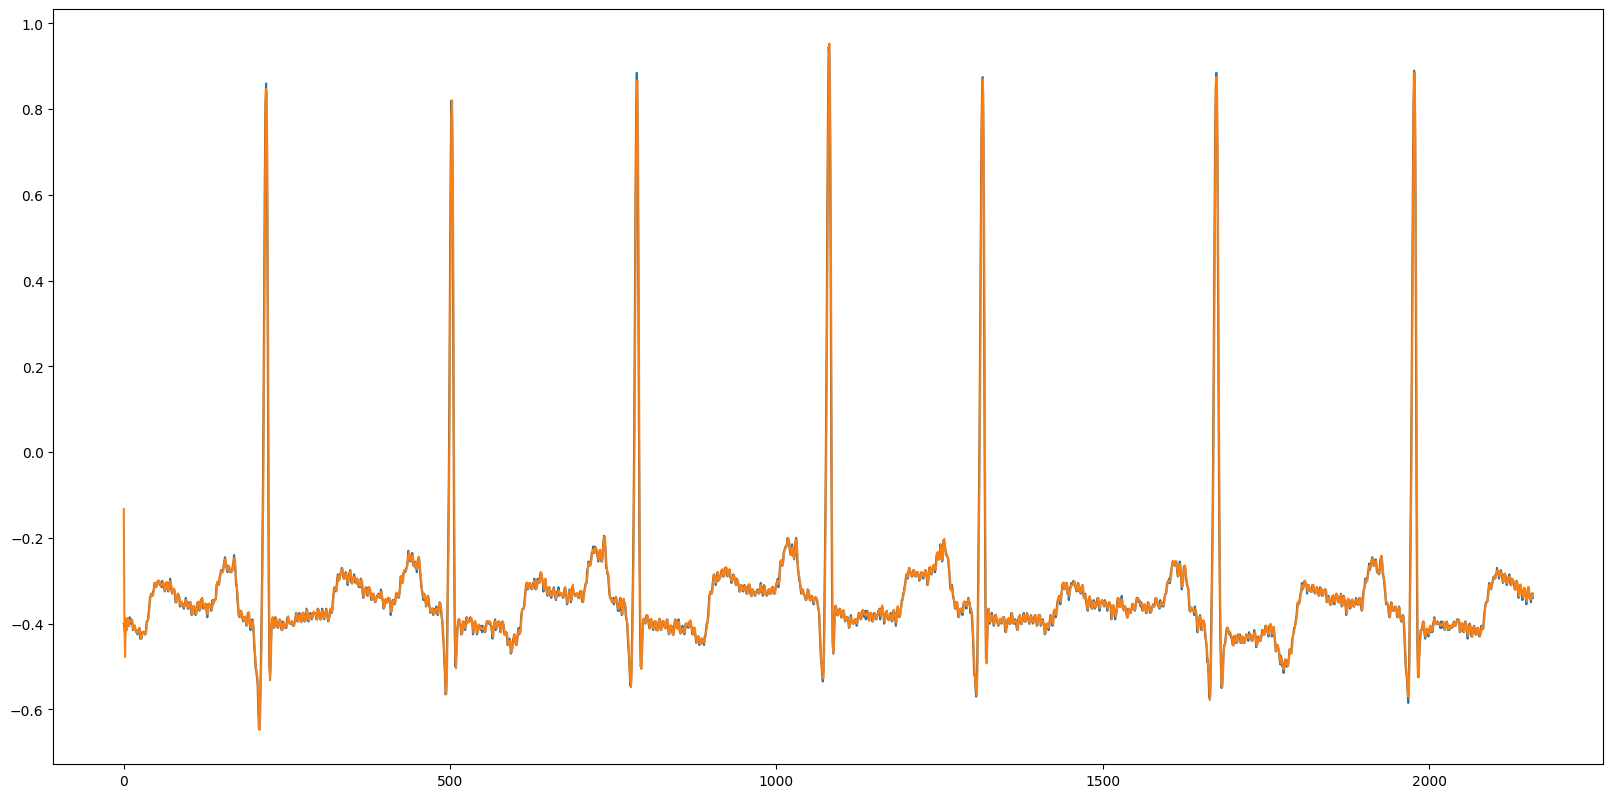

In [ ]:
plt.figure(figsize=(20,10),dpi=100)

plt.plot(p)
plt.plot(filt)

In [ ]:
#mse for wavelet denoise
mse1=mean_squared_error(p,x_denoise)
mse1

0.13050054407998818

In [ ]:
#mse for median filter 
mse2=mean_squared_error(p,med)
mse2

0.00011932870370370367

In [ ]:
#mse for gaussian filter 
mse3=mean_squared_error(p,gua)
mse3

0.00013420835411935537

In [ ]:
#mse for moving average
mse4=mean_squared_error(p,tair_moving_average)
mse4

0.0005099611111111109

In [ ]:
#mse for low pass butterworth filter 
mse5=mean_squared_error(p,filt)
mse5

0.0008891704263621715

In [ ]:
#mse for sgf
mse6=mean_squared_error(p,sg_filtered)
mse6

0.0005670647565983645

In [ ]:
#peak signal to noise ratio 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 


In [ ]:
#wavelet transform 
Psnr1=PSNR(p,x_denoise)
Psnr1

56.974680385388666

In [ ]:
#median filter 
Psnr2=PSNR(p,med)
Psnr2

87.36335438063287

In [ ]:
#gussain filter 
Psnr3=PSNR(p,gua)
Psnr3

86.85300810496834

In [ ]:
#moving average
Psnr4=PSNR(p,tair_moving_average)
Psnr4

81.055433021696

In [ ]:
#savitzky-golay filter
Psnr5=PSNR(p,sg_filtered)
Psnr5

80.59447704395672

In [ ]:
#low pass butterworth filter 
Psnr6=PSNR(p,filt)
Psnr6

78.64095351151917

In [ ]:
#signal to noise ratio
def signaltonoise(a, axis, ddof): 
    a = np.asanyarray(a) 
    m = a.mean(axis) 
    sd = a.std(axis = axis, ddof = ddof) 
    return np.where(sd == 0, 0, m / sd) 

In [ ]:
#wavelet denoise 
stn=signaltonoise(x_denoise,0 ,0 )
stn

array(-0.64306415)

In [ ]:
#median denoise
m=signaltonoise(med,0 ,0 )
m

array(-2.12080833)

In [ ]:
#gussian filter
g=signaltonoise(gua,0 ,0 )
g

array(-2.1494022)

In [ ]:
#moving average 
a=signaltonoise(tair_moving_average,0 ,0 )
a

array(-2.23430473)

In [ ]:
#savitzky-golay
s=signaltonoise(sg_filtered,0 ,0 )
s

array(-2.11948986)

In [ ]:
#low pass butterworth filter 
b=signaltonoise(filt,0 ,0 )
b

array(-2.05980413)

In [ ]:
#original signal
o=signaltonoise(p,0 ,0 )
o

array(-2.06088457)

NORMAL CNN

In [ ]:
x_train,x_valid,y_train,y_valid = train_test_split(X_all,Y_all,test_size=0.2,random_state=42)
y_train.shape
x_train.shape[1]


2160

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
               metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train,batch_size=32,epochs=6,verbose=1)

Epoch 1/6
2285/2285 [==============================] - 25s 4ms/step - loss: 0.3322 - accuracy: 0.8640
Epoch 2/6
2285/2285 [==============================] - 8s 4ms/step - loss: 0.1666 - accuracy: 0.9451
Epoch 3/6
2285/2285 [==============================] - 9s 4ms/step - loss: 0.1503 - accuracy: 0.9515
Epoch 4/6
2285/2285 [==============================] - 9s 4ms/step - loss: 0.1377 - accuracy: 0.9571
Epoch 5/6
2285/2285 [==============================] - 9s 4ms/step - loss: 0.1204 - accuracy: 0.9624
Epoch 6/6
2285/2285 [==============================] - 9s 4ms/step - loss: 0.1181 - accuracy: 0.9623


In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
def calc_prevalence(y_actual):
    return(sum(y_actual)/len(y_actual))
def calc_specificity(y_actual,y_pred,thresh):
    return sum((y_pred<thresh)&(y_actual == 0))/sum(y_actual==0)
def print_report(y_actual,y_pred,thresh):
    auc=roc_auc_score(y_actual,y_pred)
    accuracy = accuracy_score(y_actual,(y_pred>thresh))
    recall = recall_score(y_actual,(y_pred>thresh))
    precision = precision_score(y_actual,(y_pred>thresh))
    specificity = calc_specificity(y_actual,y_pred,thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc,accuracy,recall,precision,specificity

In [ ]:
y_train_preds_dense = model.predict(x_train,verbose=1)
y_valid_pred_dense  = model.predict(x_valid,verbose=1)

1126/1126 [==============================] - 1s 1ms/step


In [ ]:
thresh = (sum(y_train)/len(y_train))[0]
thresh


0.3146575923188854

In [ ]:
print('Train')
print_report(y_train,y_train_preds_dense,thresh)
print('Valid')
print_report(y_valid,y_valid_pred_dense,thresh)

Train


NameError: ignored

In [ ]:
import random
random.seed(42)
pts_train = random.sample(pts,36)
pts_valid = [pt for pt in pts if pt not in pts_train]
print(len(pts_train),len(pts_valid))


36 12


In [ ]:
x_train,y_train,sym_train = make_dataset(pts_train,num_sec,fs,abnormal)
x_valid,y_valid,sym_valid = make_dataset(pts_valid,num_sec,fs,abnormal)
print(x_train.shape,y_train.shape,len(sym_train))
print(x_valid.shape,y_valid.shape,len(sym_valid))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu',input_dim =x_train.shape[1] ))
model.add(Dropout(rate = 0.25))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(
               loss = 'binary_crossentropy',
               optimizer = 'adam',
                metrics = ['accuracy'])
model.fit(x_train,y_train,batch_size = 32,epochs=5,verbose=1)

Epoch 1/5
2520/2520 [==============================] - 8s 3ms/step - loss: 0.3227 - accuracy: 0.8738
Epoch 2/5
2520/2520 [==============================] - 8s 3ms/step - loss: 0.1508 - accuracy: 0.9544
Epoch 3/5
2520/2520 [==============================] - 8s 3ms/step - loss: 0.1215 - accuracy: 0.9630
Epoch 4/5
2520/2520 [==============================] - 7s 3ms/step - loss: 0.1147 - accuracy: 0.9660
Epoch 5/5
2520/2520 [==============================] - 7s 3ms/step - loss: 0.1049 - accuracy: 0.9686


In [ ]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.29906715955045027

In [ ]:
y_train_preds_dense = model.predict(x_train,verbose=1)
y_valid_preds_dense = model.predict(x_valid,verbose =1)

In [ ]:
print('Train')
print_report(y_train,y_train_preds_dense,thresh)
print('Valid')
print_report(y_valid,y_valid_preds_dense,thresh)

##Custom CNN

In [ ]:
def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())
def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [ ]:
# reshape input to be [sample ,time steps,features=1]
x_train_custom = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_valid_custom = np.reshape(x_valid,(x_valid.shape[0],x_valid.shape[1],1))

print(x_train_custom.shape)
print(x_valid_custom.shape)

(80614, 2160, 1)
(28485, 2160, 1)


In [ ]:
from keras.layers import Conv1D,MaxPooling1D
import tensorflow as tf 

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 600 ,kernel_size = 20, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
model.add(Conv1D(filters=400,kernel_size=15,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
model.add(Conv1D(filters=266,kernel_size=10,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Conv1D(filters=178,kernel_size=7,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Conv1D(filters=88,kernel_size=20,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))#binary activation output
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2141, 600)         12600     
_________________________________________________________________
dropout (Dropout)            (None, 2141, 600)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1070, 600)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1056, 400)         3600400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1056, 400)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 528, 400)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 519, 266)          1

In [ ]:
#compile the model
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy",sensitivity,specificity,recall,precision])


In [ ]:
#Fit the model
history_1=model.fit(x_train_custom,y_train,batch_size=32,epochs=6,verbose=1)

In [ ]:
y_train_preds_cnn2=model.predict(x_train_custom,verbose=1)
y_valid_preds_cnn2=model.predict(x_valid_custom,verbose=1)

In [ ]:
print('Train')
print_report(y_train,y_train_preds_cnn2,thresh)
print('Valid')
print_report(y_valid,y_valid_preds_cnn2,thresh)

In [ ]:
aucs_train = []
aucs_valid = []
n_pts = [1,18,36]
for n_pt in n_pts:
    
    print(n_pt)
    pts_sub = pts_train[:n_pt]
    X_sub, y_sub, sym_sub = make_dataset(pts_sub, num_sec, fs,abnormal)
    model = Sequential()
    model.add(Conv1D(filters = 600 ,kernel_size = 20, activation = 'relu', input_shape = (2160,1)))
    model.add(Dropout(rate=0.25))
    model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
    model.add(Conv1D(filters=400,kernel_size=15,activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
    model.add(Conv1D(filters=266,kernel_size=10,activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
    model.add(Conv1D(filters=178,kernel_size=7,activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
    model.add(Conv1D(filters=88,kernel_size=20,activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
   
    model.compile(
                    loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])
    model.fit(X_sub, y_sub, batch_size = 32, epochs= 6, verbose = 0)
    y_sub_preds_cnn2 = model.predict(X_sub,verbose = 0)
    y_valid_preds_cnn2 = model.predict(x_valid_custom,verbose = 0)
    auc_train = roc_auc_score(y_sub, y_sub_preds_cnn2)
    auc_valid = roc_auc_score(y_valid, y_valid_preds_cnn2)
    print('-',auc_train, auc_valid)
    aucs_train.append(auc_train)
    aucs_valid.append(auc_valid)
    

In [ ]:
plt.plot(n_pts,aucs_train,'o-',label = 'Train')
plt.plot(n_pts,aucs_valid,'o-',label= 'Valid')
plt.xlabel('Number Training pts')
plt.ylabel('auc')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
def calc_prevalence(y_actual):
    return(sum(y_actual)/len(y_actual))
def calc_specificity(y_actual,y_pred,thresh):
    return sum((y_pred<thresh)&(y_actual == 0))/sum(y_actual==0)
def print_report(y_actual,y_pred,thresh):
    auc=roc_auc_score(y_actual,y_pred)
    accuracy = accuracy_score(y_actual,(y_pred>thresh))
    recall = recall_score(y_actual,(y_pred>thresh))
    precision = precision_score(y_actual,(y_pred>thresh))
    specificity = calc_specificity(y_actual,y_pred,thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc,accuracy,recall,precision,specificity

In [ ]:
y_train_preds_dense = model.predict(x_train_custom,verbose=1)
y_valid_pred_dense  = model.predict(x_valid_custom,verbose=1)

891/891 [==============================] - 80s 90ms/step


In [ ]:
print('Train')
print_report(y_train,y_train_preds_dense,thresh)
print('Valid')
print_report(y_valid,y_valid_pred_dense,thresh)

Train
AUC:0.999
accuracy:0.992
recall:0.986
precision:0.988
specificity:0.995
prevalence:0.299
 
Valid
AUC:0.756
accuracy:0.772
recall:0.513
precision:0.775
specificity:0.917
prevalence:0.358
 


(0.7558710664191514,
 0.7724767421449886,
 0.5132908288376655,
 0.7750296208530806,
 array([0.91694915]))

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 400 ,kernel_size = 20, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate=0.5))
model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
model.add(Conv1D(filters=256,kernel_size=15,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
model.add(Conv1D(filters=178,kernel_size=7,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Conv1D(filters=88,kernel_size=5,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Conv1D(filters=44,kernel_size=3,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))#binary activation outputmodel = Sequential()
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2141, 400)         8400      
                                                                 
 dropout (Dropout)           (None, 2141, 400)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1070, 400)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1056, 256)         1536256   
                                                                 
 dropout_1 (Dropout)         (None, 1056, 256)         0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 528, 256)         0         
 1D)                                                    

In [ ]:
#compile the model
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy",sensitivity,specificity,recall,precision])


In [ ]:
#Fit the model
history=model.fit(x_train_custom,y_train,batch_size=32,epochs=6,verbose=1)

Epoch 1/6
2453/2520 [============================>.] - ETA: 13s - loss: 0.1289 - accuracy: 0.9552 - sensitivity: 0.9019 - specificity: 0.9778 - recall: 0.9019 - precision: 0.9449

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
def calc_prevalence(y_actual):
    return(sum(y_actual)/len(y_actual))
def calc_specificity(y_actual,y_pred,thresh):
    return sum((y_pred<thresh)&(y_actual == 0))/sum(y_actual==0)
def print_report(y_actual,y_pred,thresh):
    auc=roc_auc_score(y_actual,y_pred)
    accuracy = accuracy_score(y_actual,(y_pred>thresh))
    recall = recall_score(y_actual,(y_pred>thresh))
    precision = precision_score(y_actual,(y_pred>thresh))
    specificity = calc_specificity(y_actual,y_pred,thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc,accuracy,recall,precision,specificity

In [ ]:
y_train_preds_dense = model.predict(x_train_custom,verbose=1)
y_valid_pred_dense  = model.predict(x_valid_custom,verbose=1)

891/891 [==============================] - 8s 9ms/step


In [ ]:
print('Train')
print_report(y_train,y_train_preds_dense,thresh)
print('Valid')
print_report(y_valid,y_valid_pred_dense,thresh)

Train
AUC:0.999
accuracy:0.940
recall:0.997
precision:0.834
specificity:0.915
prevalence:0.299
 
Valid
AUC:0.780
accuracy:0.632
recall:0.613
precision:0.488
specificity:0.642
prevalence:0.358
 


(0.7803194326274606,
 0.6315253642267861,
 0.613339872486513,
 0.48824861403919734,
 array([0.64166211]))

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 300 ,kernel_size = 20, activation = 'relu', input_shape = (2160,1)))
model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
model.add(Conv1D(filters=250,kernel_size=15,activation='relu'))
model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
model.add(Conv1D(filters=150,kernel_size=8,activation='relu'))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Conv1D(filters=100,kernel_size=5,activation='relu'))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Conv1D(filters=50,kernel_size=3,activation='relu'))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))#binary activation outputmodel = Sequential()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2141, 300)         6300      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1070, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1056, 250)         1125250   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 528, 250)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 521, 150)          300150    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 260, 150)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 256, 100)          7

In [ ]:
#compile the model
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy",sensitivity,specificity,recall,precision])

In [ ]:
#Fit the model
history=model.fit(x_train_custom,y_train,batch_size=32,epochs=6,validation_split=0.1,verbose=1)

Epoch 1/6
2268/2268 [==============================] - 348s 139ms/step - loss: 0.0843 - accuracy: 0.9712 - sensitivity: 0.9423 - specificity: 0.9855 - recall: 0.9423 - precision: 0.9674 - val_loss: 0.2759 - val_accuracy: 0.9197 - val_sensitivity: 0.3248 - val_specificity: 0.9227 - val_recall: 0.3248 - val_precision: 0.2290
Epoch 2/6
2268/2268 [==============================] - 313s 138ms/step - loss: 0.0376 - accuracy: 0.9885 - sensitivity: 0.9774 - specificity: 0.9939 - recall: 0.9774 - precision: 0.9871 - val_loss: 0.2282 - val_accuracy: 0.9154 - val_sensitivity: 0.3560 - val_specificity: 0.9101 - val_recall: 0.3560 - val_precision: 0.2108
Epoch 3/6
2268/2268 [==============================] - 311s 137ms/step - loss: 0.0279 - accuracy: 0.9916 - sensitivity: 0.9836 - specificity: 0.9956 - recall: 0.9836 - precision: 0.9908 - val_loss: 0.4097 - val_accuracy: 0.8899 - val_sensitivity: 0.3537 - val_specificity: 0.8841 - val_recall: 0.3537 - val_precision: 0.2068
Epoch 4/6
2268/2268 [====

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
def calc_prevalence(y_actual):
    return(sum(y_actual)/len(y_actual))
def calc_specificity(y_actual,y_pred,thresh):
    return sum((y_pred<thresh)&(y_actual == 0))/sum(y_actual==0)
def print_report(y_actual,y_pred,thresh):
    auc=roc_auc_score(y_actual,y_pred)
    accuracy = accuracy_score(y_actual,(y_pred>thresh))
    recall = recall_score(y_actual,(y_pred>thresh))
    precision = precision_score(y_actual,(y_pred>thresh))
    specificity = calc_specificity(y_actual,y_pred,thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc,accuracy,recall,precision,specificity

In [ ]:
y_train_preds_dense = model.predict(x_train_custom,verbose=1)
y_valid_pred_dense  = model.predict(x_valid_custom,verbose=1)

891/891 [==============================] - 35s 39ms/step


In [ ]:
print('Train')
print_report(y_train,y_train_preds_dense,thresh)
print('Valid')
print_report(y_valid,y_valid_pred_dense,thresh)

Train


NameError: ignored

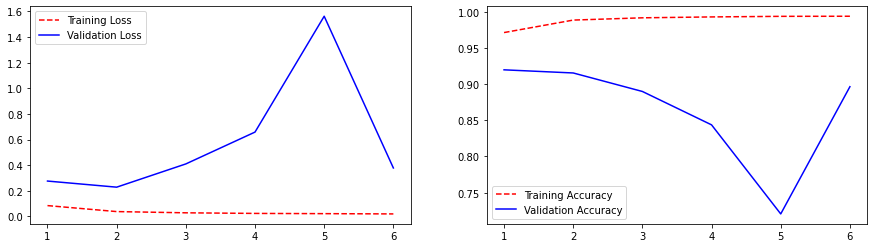

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

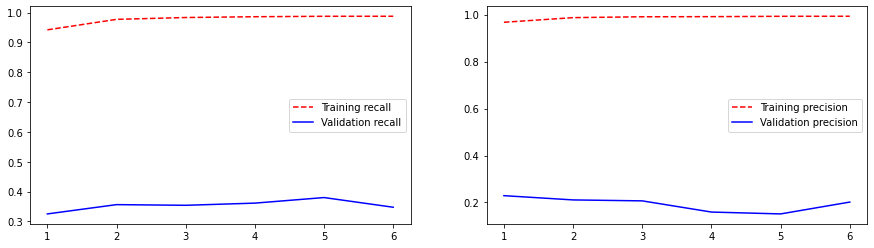

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = history.history['recall']
validation_recall = history.history['val_recall']

training_precision = history.history['precision']
validation_precision = history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])

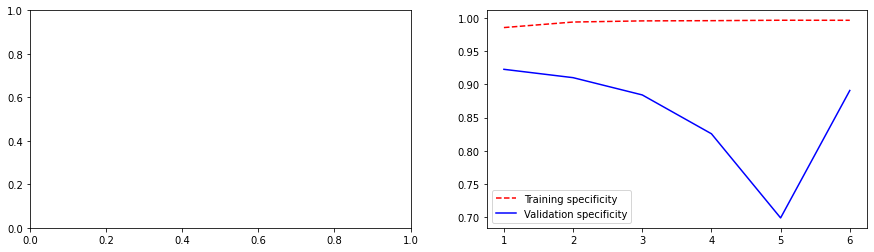

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_specificity = history.history['specificity']
validation_specificity = history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)
axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
training_sensitivity = history.history['sensitivity']
validation_sensitivity = history.history['val_sensitivity']

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 400 ,kernel_size = 30, activation = 'relu', input_shape = (2160,1)))
model.add(Conv1D(filter = 300,kernel_size = 27,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
model.add(Conv1D(filters=256,kernel_size=25,activation='relu'))
model.add(Conv1D(filters=156,kernel_size=23,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding="valid"))
model.add(Conv1D(filters=178,kernel_size=20,activation='relu'))
model.add(Conv1D(filters=100,kernel_size=17,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Conv1D(filters=88,kernel_size=15,activation='relu'))
model.add(Conv1D(filter=66,kernel_size=12,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Conv1D(filters=55,kernel_size=10,activation='relu'))
model.add(Conv1D(filter=44,kernel_size=5,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=2,strides=2,padding='valid'))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))#binary activation output
model.summary()




In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import keras_tuner as kt

In [ ]:
def build_model(hp):
  model=keras.Sequential([keras.layers.Conv1D(
                         filters=hp.Int('conv_1_filter',min_value=300,max_value=400,step=16),
                         kernel_size=hp.Choice('conv_1_kernel',[15,20]),
                         activation='relu',
                         input_shape=(2160,1) 
                         ),
                         keras.layers.MaxPooling1D(
                             pool_size=hp.Choice('pool_1',[1,2]),
                             strides=2,
                             padding='valid'),
                        keras.layers.Conv1D(filters=hp.Int('conv_1_filter',min_value=156,max_value=256,step=16),
                                            kernel_size=hp.Choice('conv_1_kernel',[10,15]),
                                             activation='relu'),
                        keras.layers.MaxPooling1D(pool_size=hp.Choice('pool_2',[1,2]),
                                                strides=2,
                                                padding='valid'),
                            
                        keras.layers.Conv1D(filters=hp.Int('conv_1_filter',min_value=100,max_value=156,step=16),
                                             kernel_size=hp.Choice('conv_1_kernel',[8,12]),
                                             activation='relu'),
                        keras.layers.MaxPooling1D(pool_size=hp.Choice('pool_2',[1,2]),
                                                strides=2,
                                                padding='valid'),
                        keras.layers.Conv1D(filters=hp.Int('conv_1_filter',min_value=44,max_value=88,step=16),
                                              kernel_size=hp.Choice('conv_1_kernel',[3,5]),
                                              activation='relu'),
                        keras.layers.MaxPooling1D(pool_size=hp.Choice('pool_3',[1,2]),
                                                strides=2,
                                                padding='valid'),
                        keras.layers.Flatten(),
                        keras.layers.Dense(units=hp.Int('dense_1-units',min_value=32,max_value=128,step=16),
                              activation='relu'
                          ),
                          keras.layers.Dense(1,activation='softmax')])
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-2,1e-3])),
              loss='binary_crossentropy',
              metrics=["accuracy",sensitivity,specificity,recall,precision])
  return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
tuner_search=kt.RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,project_name='heat_beat')

In [ ]:
tuner_search.search(x_train_custom,y_train,batch_size=32,epochs=3,validation_split = 0.2,verbose=1)

Trial 5 Complete [00h 34m 23s]
val_accuracy: 0.22756311297416687

Best val_accuracy So Far: 0.22756311297416687
Total elapsed time: 02h 47m 31s
INFO:tensorflow:Oracle triggered exit
